# Caracterização do Perfil do Jato de gás

### Chamada de bibliotecas

Utilização de biblioteca PyAbel para caraccterização do feixe

In [97]:
%matplotlib nbagg
import abel
import scipy
import cmath
import convertapi
import matplotlib 
import numpy as np
from typing import Tuple
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.backend_bases import MouseButton
from mpl_point_clicker import clicker
from scipy.fft import fft, ifft
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
import mplcursors

from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

In [99]:
originalgas = Image.open('./Images/im.png')
phase_gas = np.asarray(originalgas)

print(np.shape(phase_gas))

(321, 480, 3)


(70.0, 100.0)
(101, 191)


<IPython.core.display.Javascript object>


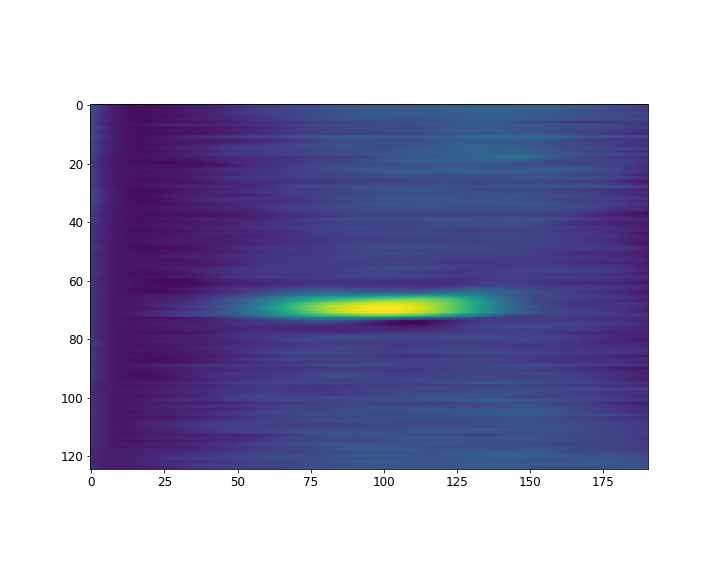

In [137]:
myArray = []
fo = open("./Images/d1.txt", "r")
for line in fo:
    for nbr in line.split(','):
        myArray.append(float(nbr))
            
original = np.reshape(myArray,(125,191))

cx,cy = np.where(original==original.max())
origin = (np.median(cx),np.median(cy))
print(origin)

original_com = gaussian_filter(original,sigma = 5)#[:,int(cy-300):int(cy+301)],sigma = 8)

delta = 50
gas_dens = original_com[int(cx-delta):int(cx+delta+1)]-np.min(original_com[int(cx-delta):int(cx+1+delta)])

print(np.shape(gas_dens))


fig, ax = plt.subplots(figsize=(10,8))
plt.imshow(np.asarray(original))

<IPython.core.display.Javascript object>


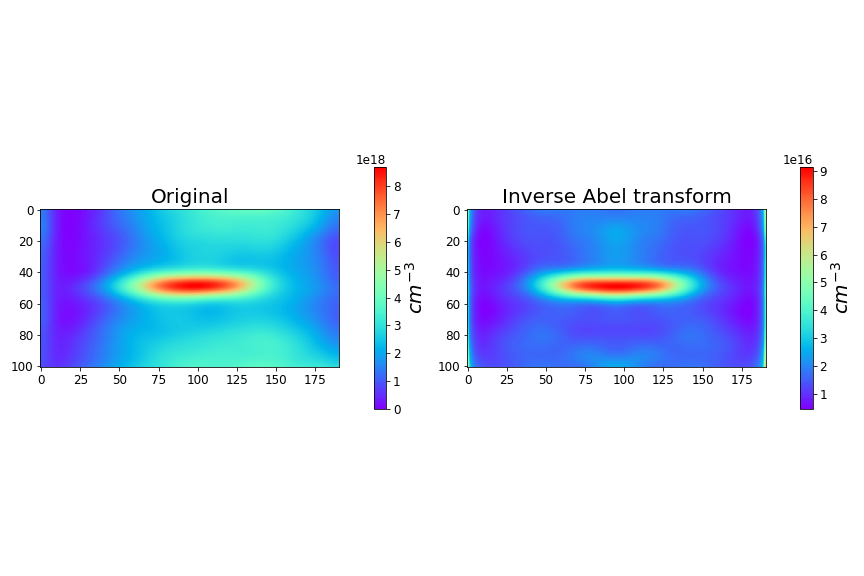

In [138]:
gas_dens_abel = abel.Transform(gas_dens, symmetry_axis=0, direction='inverse', method='three_point').transform

fig,(ax0, ax1) = plt.subplots(1,2, figsize=(12, 8))

original_plot = ax0.imshow(gas_dens, cmap='rainbow')
abel_plot = ax1.imshow(gas_dens_abel, cmap='rainbow')

cb0 = fig.colorbar(original_plot, ax=ax0, fraction = 0.035, pad =0.1)
cb1 = fig.colorbar(abel_plot, ax=ax1, label='$cm^{-3}$',fraction = 0.035, pad =0.1)

cb0.set_label(label='$cm^{-3}$', size=20, weight='bold')
cb1.set_label(label='$cm^{-3}$', size=20, weight='bold')

ax0.set_title('Original',size=20)
ax1.set_title('Inverse Abel transform',size =20)
fig.tight_layout()
plt.show()

### Imagem Original do Interferômetro

In [2]:
#Imagens do interferograma
originalref = Image.open('./Images/imgplasma1.png')
originalgas = Image.open('./Images/imgplasma2.png')

phase_ref = np.asarray(originalref)
phase_gas = np.asarray(originalgas)

#Fatiar imagem com 3 canais
intref = phase_ref#[:,:,0]
intgas = phase_gas#[:,:,0]

<IPython.core.display.Javascript object>


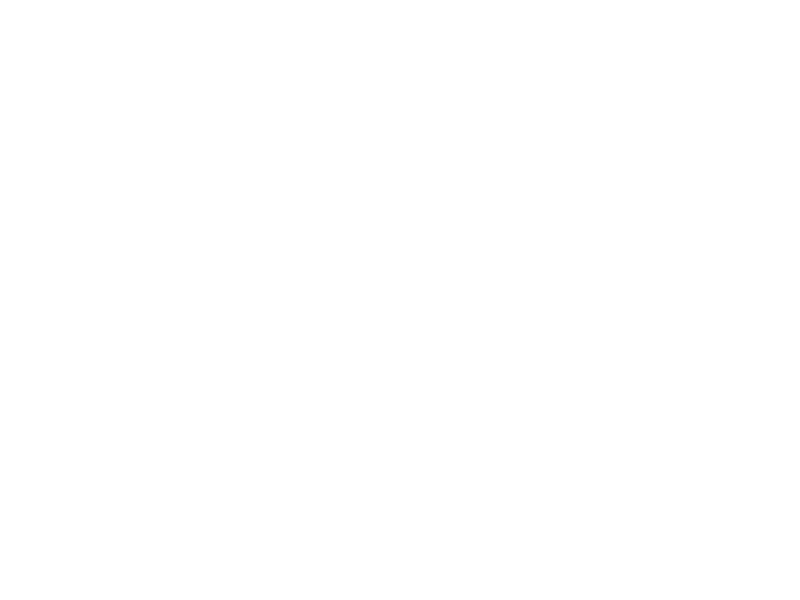

In [3]:
# Verificar imagens
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].imshow(intref, cmap='gray')
axs[1].imshow(intgas, cmap='gray')

axs[0].set_title('Ref')
axs[1].set_title('gas')

plt.tight_layout()
plt.show()

### Aplicar TF na imagem

In [4]:
#Calcular transformada de fourier das imagens
fftref = np.fft.fft2(intref)
fftgas = np.fft.fft2(intgas)

<IPython.core.display.Javascript object>


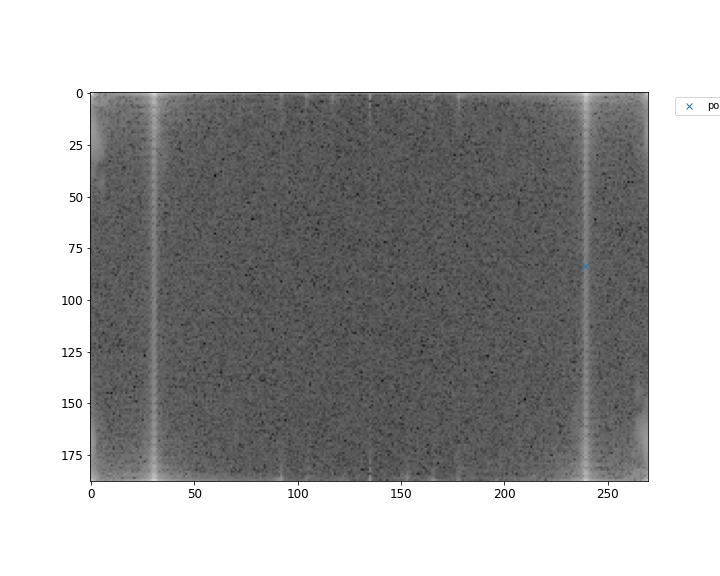

In [64]:
#Determinar pontos de referência para corte e rotação
%matplotlib nbagg
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(np.log(np.abs(fftref)), cmap='gray')
klicker = clicker(ax, ['points'], markers=['x'])


def point_added_cb(position: Tuple[float, float], klass: str):
    x, y = position
    print(f"New point of class {klass} added at {x=}, {y=}")


def point_removed_cb(position: Tuple[float, float], klass: str, idx):
    x, y = position

    suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(idx, 'th')
    print(
        f"The {idx}{suffix} point of class {klass} with position {x=:.2f}, {y=:.2f}  was removed"
    )

klicker.on_point_added(point_added_cb)
klicker.on_point_removed(point_removed_cb)

plt.show()

In [65]:
max_nlines, max_nrows = np.shape(fftgas)
#Pontos de referência do filtro

#Horizontal
#centerfilter = int((klicker.get_positions())['points'][0][1])

#Vertical
centerfilter = int((klicker.get_positions())['points'][0][0])
sigma = 5

print(centerfilter)

239


In [66]:
#Criando matrizes nulas
gfilter = np.zeros(np.shape(fftgas))

#filtro
#Horizontal
#gfilter[centerfilter-sigma:centerfilter+sigma][:] = np.ones(np.shape(
#    fftgas[centerfilter-sigma:centerfilter+sigma][:]))

#Vertical
gfilter[:,centerfilter-sigma:centerfilter+sigma]= np.ones(np.shape(
    fftgas[:,centerfilter-sigma:centerfilter+sigma]))


### Aplicar Filtro Gaussiano

In [67]:
gfilter[:,centerfilter-3*sigma:centerfilter+3*sigma] =\
    gaussian_filter(gfilter[:,centerfilter-3*sigma:centerfilter+3*sigma],sigma=8)

<IPython.core.display.Javascript object>


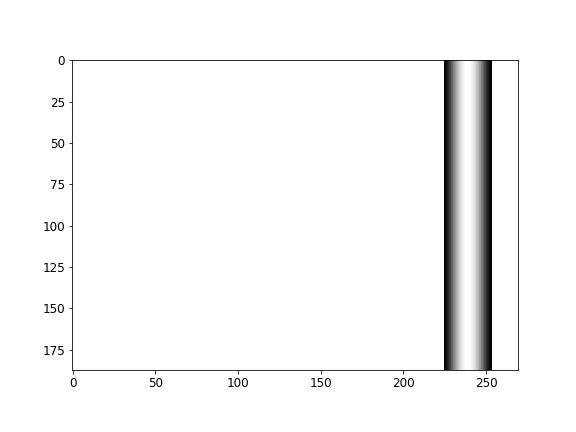

/tmp/ipykernel_21312/3083541519.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(gfilter)), cmap='gray')


In [68]:
plt.figure(figsize=(8,6))
plt.imshow(np.log(np.abs(gfilter)), cmap='gray')
plt.show()

### Transformada inversa da Imagem

In [69]:
#Calcullar a TF inversa
ifftref = np.fft.ifft2(gfilter*fftref)
ifftgas = np.fft.ifft2(gfilter*fftgas)

<IPython.core.display.Javascript object>


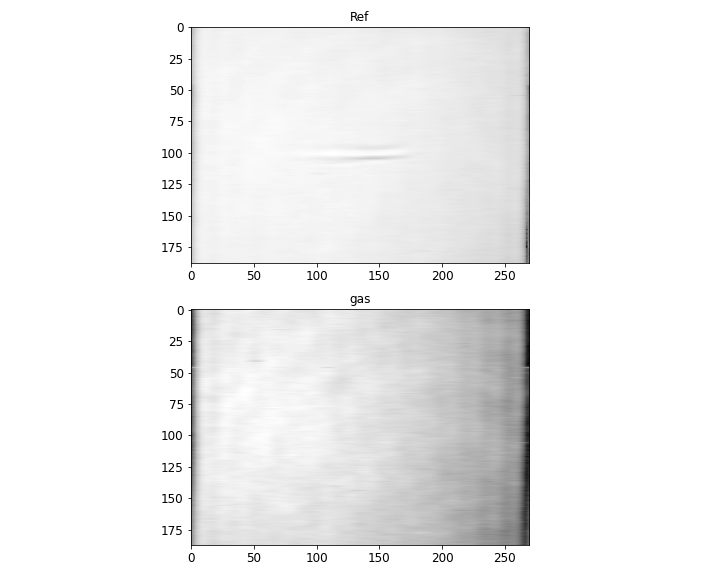

In [70]:
# Verificar imagens
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].imshow(np.log(np.abs(ifftref)), cmap='gray')
axs[1].imshow(np.log(np.abs(ifftgas)), cmap='gray')

axs[0].set_title('Ref')
axs[1].set_title('gas')

plt.tight_layout()
plt.show()

In [71]:
#Subtração das transformadas inversas e calculo do argumento
result = np.angle(ifftgas)-np.angle(ifftref)

In [72]:
baseline = abs(np.min(result))
print(baseline)

5.316824855230228


<IPython.core.display.Javascript object>


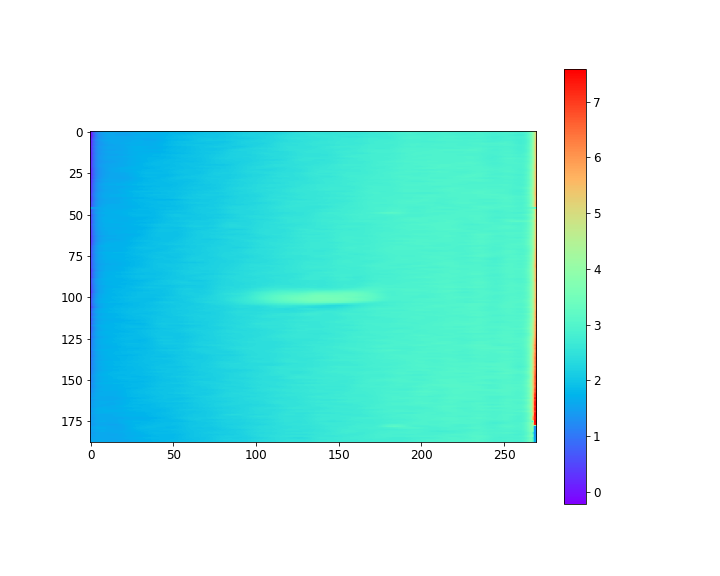

In [73]:
perfil = (unwrap_phase(result+baseline))#-np.ones(np.shape(result))*np.min(result))
perfil=perfil
plt.figure(figsize=(10,8))

mplcursors.cursor()
plt.tight_layout()
plt.imshow(perfil, cmap='rainbow')
plt.colorbar()

In [17]:
np.shape(perfil)

(188, 270)

In [74]:
cx,cy = np.where(perfil==perfil.max())
origin = (np.median(cx),np.median(cy))
print(origin)

(100.0, 125.0)


In [75]:
perfil_com = gaussian_filter(perfil,sigma = 10)#[:,int(cy-300):int(cy+301)],sigma = 8)

In [76]:
inverse_abel = abel.Transform(perfil_com, symmetry_axis=1, direction='inverse',
                              method='three_point', verbose=True, angular_integration = True).transform

In [77]:
delta = 99
original_corr = perfil_com[1:,int(cy-delta):int(cy+delta+1)]-np.min(perfil_com[1:,int(cy-delta):int(cy+1+delta)])
abel_corr = inverse_abel[1:,int(cy-delta):int(cy+1+delta)]-np.min(inverse_abel[1:,int(cy-delta):int(cy+1+delta)])
print(np.shape(original_corr))

(187, 199)


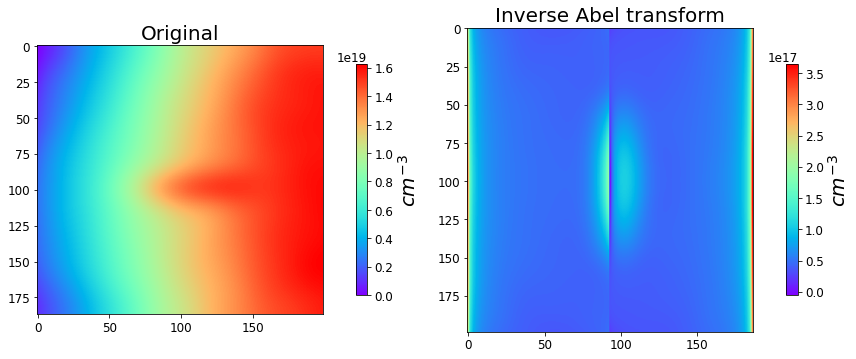

In [78]:
#definir comp. de bordas a partir do FWHM do ajuste de curvas gaussianas para cada linha da imagem
#Define the Gaussian function
#determinar o indice de refração
lambda0 = 395e-7 #cm
alpha_N2 = 1.7e-24 #cm3

%matplotlib inline
gas_dens =[]
nlines,nrows = np.shape(original_corr)
factor = 0.0002462923728813559

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

border_comp = 2*100*factor# 2*fit_parameters[2]*factor#pixel pra cm
#determinar o indice de refração    
index_n = 1 + (original_corr*lambda0)/(2*np.pi*border_comp)

#densidade do gas
gas_dens = ((3/(4*np.pi*alpha_N2))*((index_n**2-1)/(index_n**2+2)))


gas_dens_abel = abel.Transform(np.transpose(np.asarray(gas_dens)),origin = 'image_center', symmetry_axis=1, direction='inverse', 
                               method='three_point').transform

fig,(ax0, ax1) = plt.subplots(1,2, figsize=(12, 8))

original_plot = ax0.imshow(gas_dens, cmap='rainbow')
abel_plot = ax1.imshow(gas_dens_abel, cmap='rainbow')

cb0 = fig.colorbar(original_plot, ax=ax0, fraction = 0.035, pad =0.1)
cb1 = fig.colorbar(abel_plot, ax=ax1, label='$cm^{-3}$',fraction = 0.035, pad =0.1)

cb0.set_label(label='$cm^{-3}$', size=20, weight='bold')
cb1.set_label(label='$cm^{-3}$', size=20, weight='bold')

ax0.set_title('Original',size=20)
ax1.set_title('Inverse Abel transform',size =20)
fig.tight_layout()
plt.show()

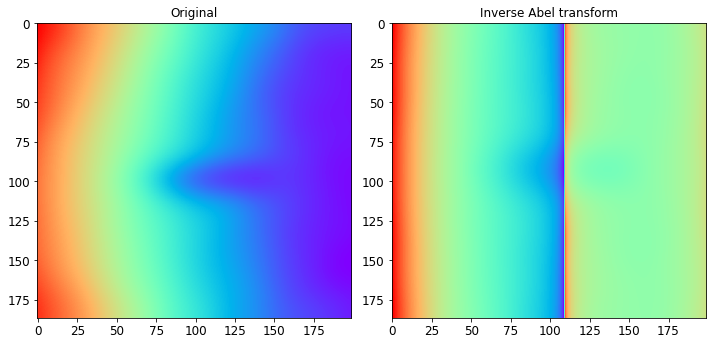

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].imshow(original_corr, cmap='rainbow')
axs[1].imshow(abel_corr, cmap='rainbow')

axs[0].set_title('Original')
axs[1].set_title('Inverse Abel transform')

plt.tight_layout()
plt.show()

In [47]:
%matplotlib inline

def perfilscan(i=nlines-1):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    y1 = abel_corr[i][:]#[100:nrows-100]
    y0 = original_corr[i][:]#[100:nrows-100]
    x = np.arange(0,nrows,1)#(100,nrows-100,1)
    
    #determinando comprimento da borda do jato a partir da gaussiana
    #x1_orig,x2_orig = np.where(y==0.05*perfil.max())
    
    axs[0].set_title('Original')
    axs[1].set_title('Inverse Abel transform')
    axs[0].plot(x,y0)
    axs[1].plot(x,y1,'red')
    
    plt.show()

interact(perfilscan,i=(0,nlines))

interactive(children=(IntSlider(value=187, description='i', max=188), Output()), _dom_classes=('widget-interac…

<function __main__.perfilscan(i=187)>

In [458]:
#determinar o indice de refração
lambda0 = 395e-7 #cm
alpha_N2 = 1.7e-24 #cm3

factor = 0.0002462923728813559
border_comp = 200*factor#pixel pra cm+2y1 = inverse_abel[500][int(cy-300):int(cy+301)]


index_n = 1 + (y0*lambda0)/(2*np.pi*border_comp)

dens = (3/(4*np.pi*alpha_N2))*((index_n**2-1)/(index_n**2+2))

plt.plot(dens)

NameError: name 'y0' is not defined

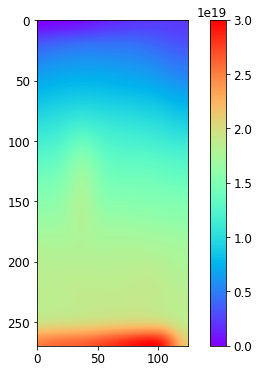

In [459]:
plt.figure(figsize=(8,6))
index_n2 = 1 + (original_corr*lambda0)/(2*np.pi*border_comp)

dens2 = (3/(4*np.pi*alpha_N2))*((index_n2**2-1)/(index_n2**2+2))

plt.imshow(dens2, cmap='rainbow')
plt.colorbar()